In [1]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

# Import some extra modules
import re

# Import data visualisation modules.
import matplotlib.pyplot as plt

In [2]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_na_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_na+.pkl')
TrainSet_cl_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_cl-.pkl')

In [3]:
# Rename all the keys in train_set_cl so that they follow on
# from the previous dictionary; this allows merging
TrainSet_na_len = len(TrainSet_na_dict.keys())
TrainSet_cl_len = len(TrainSet_cl_dict.keys())
print(TrainSet_na_len)
print(TrainSet_cl_len)
TrainSet_cl_arr = []
for key in TrainSet_cl_dict.keys():
    TrainSet_cl_arr.append(key)

for _ in TrainSet_cl_arr:
    old_key = _
    new_key = _ + TrainSet_na_len
    TrainSet_cl_dict[new_key] = TrainSet_cl_dict[old_key]
    del TrainSet_cl_dict[old_key]

# Merge the Na+ and Cl- charge balanced dictionaries
TrainSet_dict = TrainSet_na_dict | TrainSet_cl_dict
print(len(TrainSet_dict))

5000
5000
10000


In [4]:
# Filter any error filled runs and create errorless datasets
dataset_all_dict, error_all_dict = hp.filter_errors(TrainSet_dict)
dataset_na_dict, error_na_dict = hp.filter_errors(TrainSet_na_dict)
dataset_cl_dict, error_cl_dict = hp.filter_errors(TrainSet_cl_dict)

Returned 5316 files without errors out of a total possible 10000.
4684 files had errors.
0 files had unhandled errors.
File failure rate: 88.11136192626034 %.
To see unhandled errors, run with verbose=True.
Returned 2471 files without errors out of a total possible 5000.
2529 files had errors.
0 files had unhandled errors.
File failure rate: 102.34722784297855 %.
To see unhandled errors, run with verbose=True.
Returned 2845 files without errors out of a total possible 5000.
2155 files had errors.
0 files had unhandled errors.
File failure rate: 75.7469244288225 %.
To see unhandled errors, run with verbose=True.


In [5]:
attributes_all_df = attr.get_condition(dataset_all_dict,"basalt",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, ['Ca++', 'Fe++', 'Mg++', 'HCO3-']]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++,HCO3-
0,0.000030,0.000262,0.000121,0.82
1,0.000071,0.000244,0.000245,0.82
2,0.000183,0.000048,0.000124,0.82
3,0.000157,0.000085,0.000127,0.82
4,0.000053,0.000019,0.000237,0.82
...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82
5312,0.000245,0.000107,0.000123,0.82
5313,0.000176,0.000031,0.000255,0.82
5314,0.000272,0.000215,0.000171,0.82


In [6]:
def get_condition_ph(complete_dict, condition):
    index_vals = []
    ph_vals = []
    for _ in complete_dict.keys():
        index_vals.append(_)
        ph_vals.append(complete_dict[_].condition_blocks[condition].contents['pH'])
    ph_df = pd.DataFrame(ph_vals, index=index_vals, columns=['pH'])
    ph_df = ph_df.reset_index(drop=True)
    return ph_df

ph_df = get_condition_ph(dataset_all_dict, "basalt")

attributes_all_df =  pd.concat([attributes_all_df, ph_df], axis=1)
attributes_all_df

,Ca++,Fe++,Mg++,HCO3-,pH
0,0.000030,0.000262,0.000121,0.82,4.533987010208772
1,0.000071,0.000244,0.000245,0.82,4.6355729656454905
2,0.000183,0.000048,0.000124,0.82,4.266688527662164
3,0.000157,0.000085,0.000127,0.82,4.93744987421191
4,0.000053,0.000019,0.000237,0.82,4.320066725459632
...,...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82,3.5183910175187125
5312,0.000245,0.000107,0.000123,0.82,3.036155925072882
5313,0.000176,0.000031,0.000255,0.82,3.4486894430649
5314,0.000272,0.000215,0.000171,0.82,3.747021276313699


In [7]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [8]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [9]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions
FinalVols_ds = lbls.raw(dataset_all_dict, 'volume')
FinalVols_ds = NrFormatFixer_XYZTime(FinalVols_ds)
FinalVols_ds = FinalVols_ds.astype(float)

InitialVols_ds = attr.initial_conditions(dataset_all_dict, concentrations=False, minerals=True)
InitialVols_ds = NrFormatFixer_XYZ(InitialVols_ds)
InitialVols_ds = InitialVols_ds.astype(float)

# Generation of an xarray dataset representing change in mineralogical volume fractions
DeltVolFrac_ds = FinalVols_ds - InitialVols_ds

# Generation of an narrowed-down xarray dataset containing only data on a specific time and place
DeltVolFrac_TenYr_ds = DeltVolFrac_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)

# Generation of an additional xarray variable entitled Carbonates; placed into the above xarray dataset
DeltVolFrac_TenYr_ds = DeltVolFrac_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_TenYr_ds: DeltVolFrac_TenYr_ds.Calcite + DeltVolFrac_TenYr_ds.Siderite + DeltVolFrac_TenYr_ds.Magnesite)

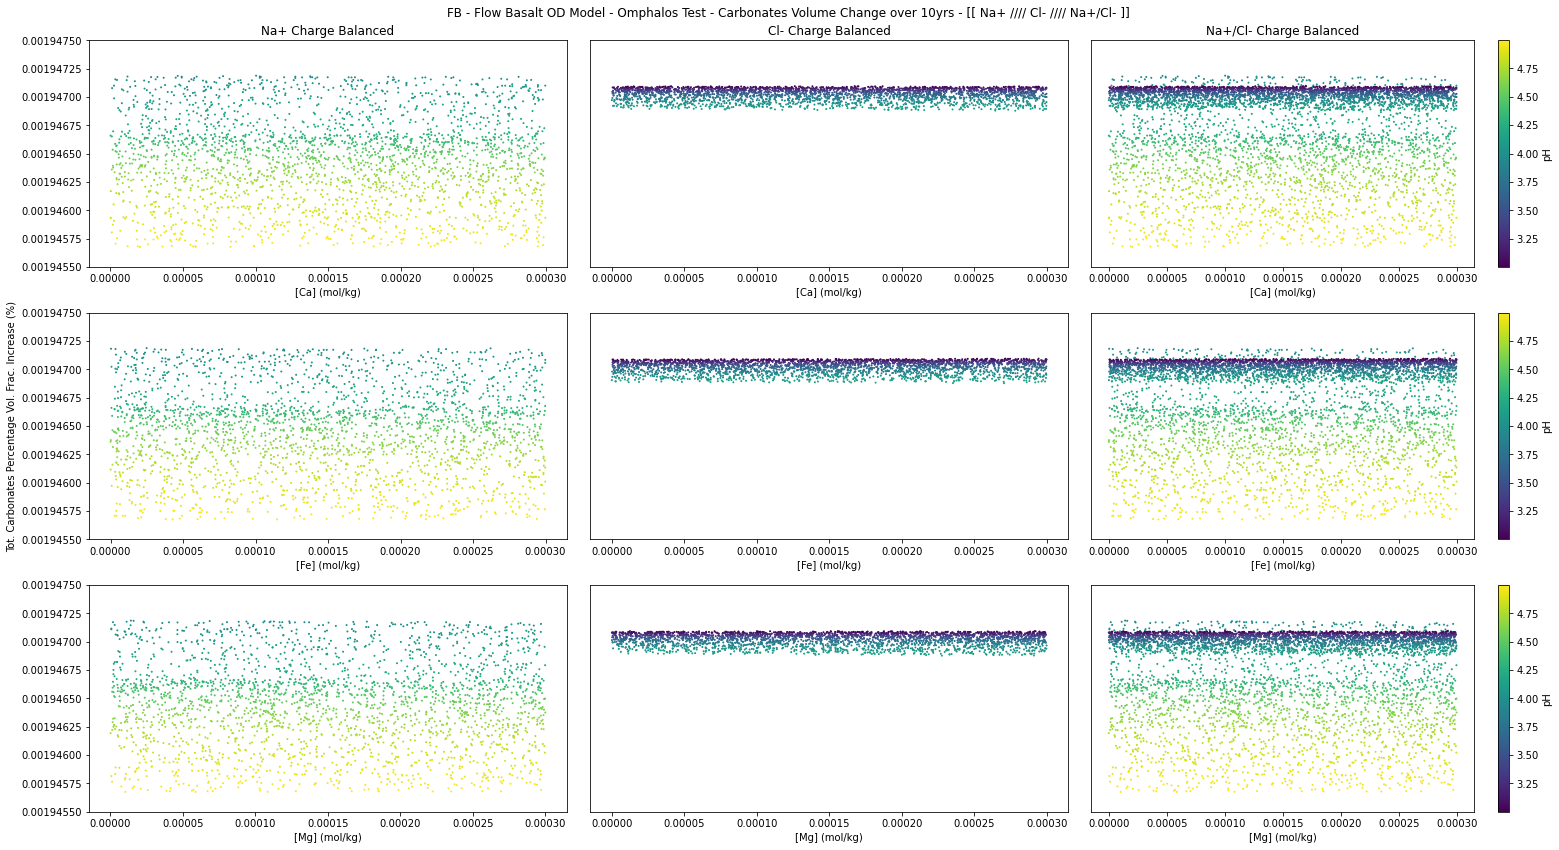

In [10]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - [[ Na+ //// Cl- //// Na+/Cl- ]]')

fig.set_figheight(12)
fig.set_figwidth(22)

ax1.set_title("Na+ Charge Balanced", loc='center')
ax2.set_title("Cl- Charge Balanced", loc='center')
ax3.set_title("Na+/Cl- Charge Balanced", loc='center')

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax7.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax3.set_xlabel('[Ca++] (mol/kg)')
ax6.set_xlabel('[Fe++] (mol/kg)')
ax9.set_xlabel('[Mg++] (mol/kg)')

ax1.yaxis.label.set_visible(False)
ax7.yaxis.label.set_visible(False)

ax1.xaxis.set_label_text('[Ca] (mol/kg)')
ax2.xaxis.set_label_text('[Ca] (mol/kg)')
ax3.xaxis.set_label_text('[Ca] (mol/kg)')
ax4.xaxis.set_label_text('[Fe] (mol/kg)')
ax5.xaxis.set_label_text('[Fe] (mol/kg)')
ax6.xaxis.set_label_text('[Fe] (mol/kg)')
ax7.xaxis.set_label_text('[Mg] (mol/kg)')
ax8.xaxis.set_label_text('[Mg] (mol/kg)')
ax9.xaxis.set_label_text('[Mg] (mol/kg)')

ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)
ax6.axes.yaxis.set_visible(False)
ax8.axes.yaxis.set_visible(False)
ax9.axes.yaxis.set_visible(False)

ax1.set_ylim(bottom=0.0019455, top=0.0019475)
ax2.set_ylim(bottom=0.0019455, top=0.0019475)
ax3.set_ylim(bottom=0.0019455, top=0.0019475)
ax4.set_ylim(bottom=0.0019455, top=0.0019475)
ax5.set_ylim(bottom=0.0019455, top=0.0019475)
ax6.set_ylim(bottom=0.0019455, top=0.0019475)
ax7.set_ylim(bottom=0.0019455, top=0.0019475)
ax8.set_ylim(bottom=0.0019455, top=0.0019475)
ax9.set_ylim(bottom=0.0019455, top=0.0019475)

_min, _max = np.amin(attributes_all_df['pH'].values.astype(float)), np.amax(attributes_all_df['pH'].values.astype(float))

ax1_x = attributes_all_df["Ca++"].values[0:len(dataset_na_dict)]
ax1_y = DeltVolFrac_TenYr_ds.Carbonates.values[0:len(dataset_na_dict)]
ax1_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax2_x = attributes_all_df["Ca++"].values[len(dataset_na_dict):]
ax2_y = DeltVolFrac_TenYr_ds.Carbonates.values[len(dataset_na_dict):]
ax2_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax3_x = attributes_all_df["Ca++"].values
ax3_y = DeltVolFrac_TenYr_ds.Carbonates.values
ax3_c = attributes_all_df['pH'].values.astype(float)

ax4_x = attributes_all_df["Fe++"].values[0:len(dataset_na_dict)]
ax4_y = DeltVolFrac_TenYr_ds.Carbonates.values[0:len(dataset_na_dict)]
ax4_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax5_x = attributes_all_df["Fe++"].values[len(dataset_na_dict):]
ax5_y = DeltVolFrac_TenYr_ds.Carbonates.values[len(dataset_na_dict):]
ax5_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax6_x = attributes_all_df["Fe++"].values
ax6_y = DeltVolFrac_TenYr_ds.Carbonates.values
ax6_c = attributes_all_df['pH'].values.astype(float)

ax7_x = attributes_all_df["Mg++"].values[0:len(dataset_na_dict)]
ax7_y = DeltVolFrac_TenYr_ds.Carbonates.values[0:len(dataset_na_dict)]
ax7_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax8_x = attributes_all_df["Mg++"].values[len(dataset_na_dict):]
ax8_y = DeltVolFrac_TenYr_ds.Carbonates.values[len(dataset_na_dict):]
ax8_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax9_x = attributes_all_df["Mg++"].values
ax9_y = DeltVolFrac_TenYr_ds.Carbonates.values
ax9_c = attributes_all_df['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, c=ax1_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im2 = ax2.scatter(x=ax2_x, y=ax2_y, c=ax2_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im3 = ax3.scatter(x=ax3_x, y=ax3_y, c=ax3_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im4 = ax4.scatter(x=ax4_x, y=ax4_y, c=ax4_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im5 = ax5.scatter(x=ax5_x, y=ax5_y, c=ax5_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im6 = ax6.scatter(x=ax6_x, y=ax6_y, c=ax6_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im7 = ax7.scatter(x=ax7_x, y=ax7_y, c=ax7_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im8 = ax8.scatter(x=ax8_x, y=ax8_y, c=ax8_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im9 = ax9.scatter(x=ax9_x, y=ax9_y, c=ax9_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)

fig.colorbar(im1, ax=ax3, label='pH')
fig.colorbar(im4, ax=ax6, label='pH')
fig.colorbar(im7, ax=ax9, label='pH')

fig.tight_layout()

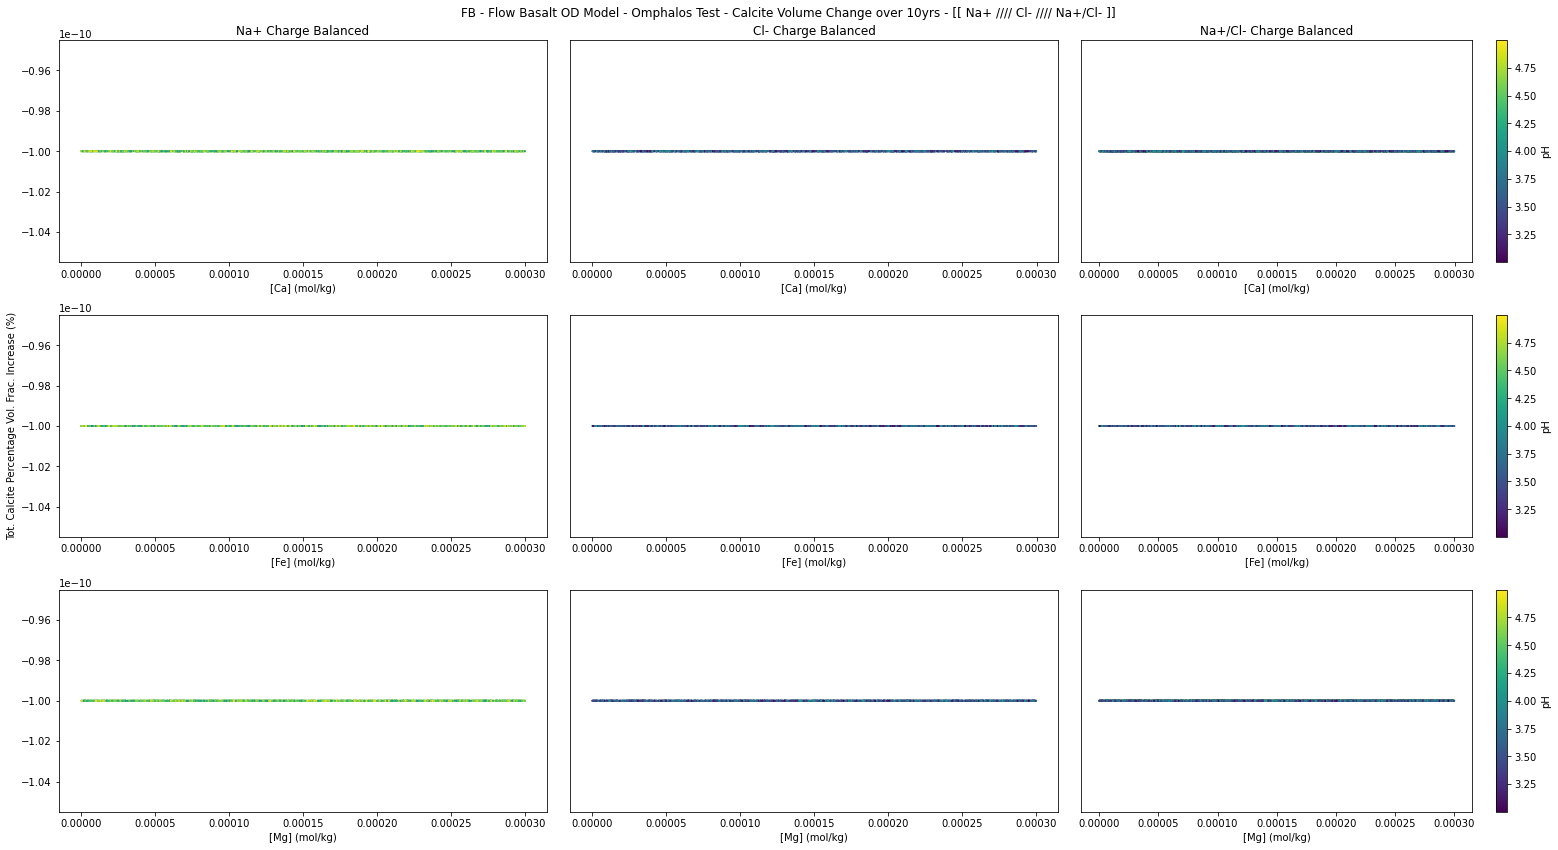

In [11]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Calcite Volume Change over 10yrs - [[ Na+ //// Cl- //// Na+/Cl- ]]')

fig.set_figheight(12)
fig.set_figwidth(22)

ax1.set_title("Na+ Charge Balanced", loc='center')
ax2.set_title("Cl- Charge Balanced", loc='center')
ax3.set_title("Na+/Cl- Charge Balanced", loc='center')

ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax7.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax3.set_xlabel('[Ca++] (mol/kg)')
ax6.set_xlabel('[Fe++] (mol/kg)')
ax9.set_xlabel('[Mg++] (mol/kg)')

ax1.yaxis.label.set_visible(False)
ax7.yaxis.label.set_visible(False)

ax1.xaxis.set_label_text('[Ca] (mol/kg)')
ax2.xaxis.set_label_text('[Ca] (mol/kg)')
ax3.xaxis.set_label_text('[Ca] (mol/kg)')
ax4.xaxis.set_label_text('[Fe] (mol/kg)')
ax5.xaxis.set_label_text('[Fe] (mol/kg)')
ax6.xaxis.set_label_text('[Fe] (mol/kg)')
ax7.xaxis.set_label_text('[Mg] (mol/kg)')
ax8.xaxis.set_label_text('[Mg] (mol/kg)')
ax9.xaxis.set_label_text('[Mg] (mol/kg)')

ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)
ax6.axes.yaxis.set_visible(False)
ax8.axes.yaxis.set_visible(False)
ax9.axes.yaxis.set_visible(False)

_min, _max = np.amin(attributes_all_df['pH'].values.astype(float)), np.amax(attributes_all_df['pH'].values.astype(float))

ax1_x = attributes_all_df["Ca++"].values[0:len(dataset_na_dict)]
ax1_y = DeltVolFrac_TenYr_ds.Calcite.values[0:len(dataset_na_dict)]
ax1_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax2_x = attributes_all_df["Ca++"].values[len(dataset_na_dict):]
ax2_y = DeltVolFrac_TenYr_ds.Calcite.values[len(dataset_na_dict):]
ax2_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax3_x = attributes_all_df["Ca++"].values
ax3_y = DeltVolFrac_TenYr_ds.Calcite.values
ax3_c = attributes_all_df['pH'].values.astype(float)

ax4_x = attributes_all_df["Fe++"].values[0:len(dataset_na_dict)]
ax4_y = DeltVolFrac_TenYr_ds.Calcite.values[0:len(dataset_na_dict)]
ax4_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax5_x = attributes_all_df["Fe++"].values[len(dataset_na_dict):]
ax5_y = DeltVolFrac_TenYr_ds.Calcite.values[len(dataset_na_dict):]
ax5_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax6_x = attributes_all_df["Fe++"].values
ax6_y = DeltVolFrac_TenYr_ds.Calcite.values
ax6_c = attributes_all_df['pH'].values.astype(float)

ax7_x = attributes_all_df["Mg++"].values[0:len(dataset_na_dict)]
ax7_y = DeltVolFrac_TenYr_ds.Calcite.values[0:len(dataset_na_dict)]
ax7_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax8_x = attributes_all_df["Mg++"].values[len(dataset_na_dict):]
ax8_y = DeltVolFrac_TenYr_ds.Calcite.values[len(dataset_na_dict):]
ax8_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax9_x = attributes_all_df["Mg++"].values
ax9_y = DeltVolFrac_TenYr_ds.Calcite.values
ax9_c = attributes_all_df['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, c=ax1_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im2 = ax2.scatter(x=ax2_x, y=ax2_y, c=ax2_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im3 = ax3.scatter(x=ax3_x, y=ax3_y, c=ax3_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im4 = ax4.scatter(x=ax4_x, y=ax4_y, c=ax4_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im5 = ax5.scatter(x=ax5_x, y=ax5_y, c=ax5_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im6 = ax6.scatter(x=ax6_x, y=ax6_y, c=ax6_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im7 = ax7.scatter(x=ax7_x, y=ax7_y, c=ax7_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im8 = ax8.scatter(x=ax8_x, y=ax8_y, c=ax8_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im9 = ax9.scatter(x=ax9_x, y=ax9_y, c=ax9_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)

fig.colorbar(im1, ax=ax3, label='pH')
fig.colorbar(im4, ax=ax6, label='pH')
fig.colorbar(im7, ax=ax9, label='pH')

fig.tight_layout()

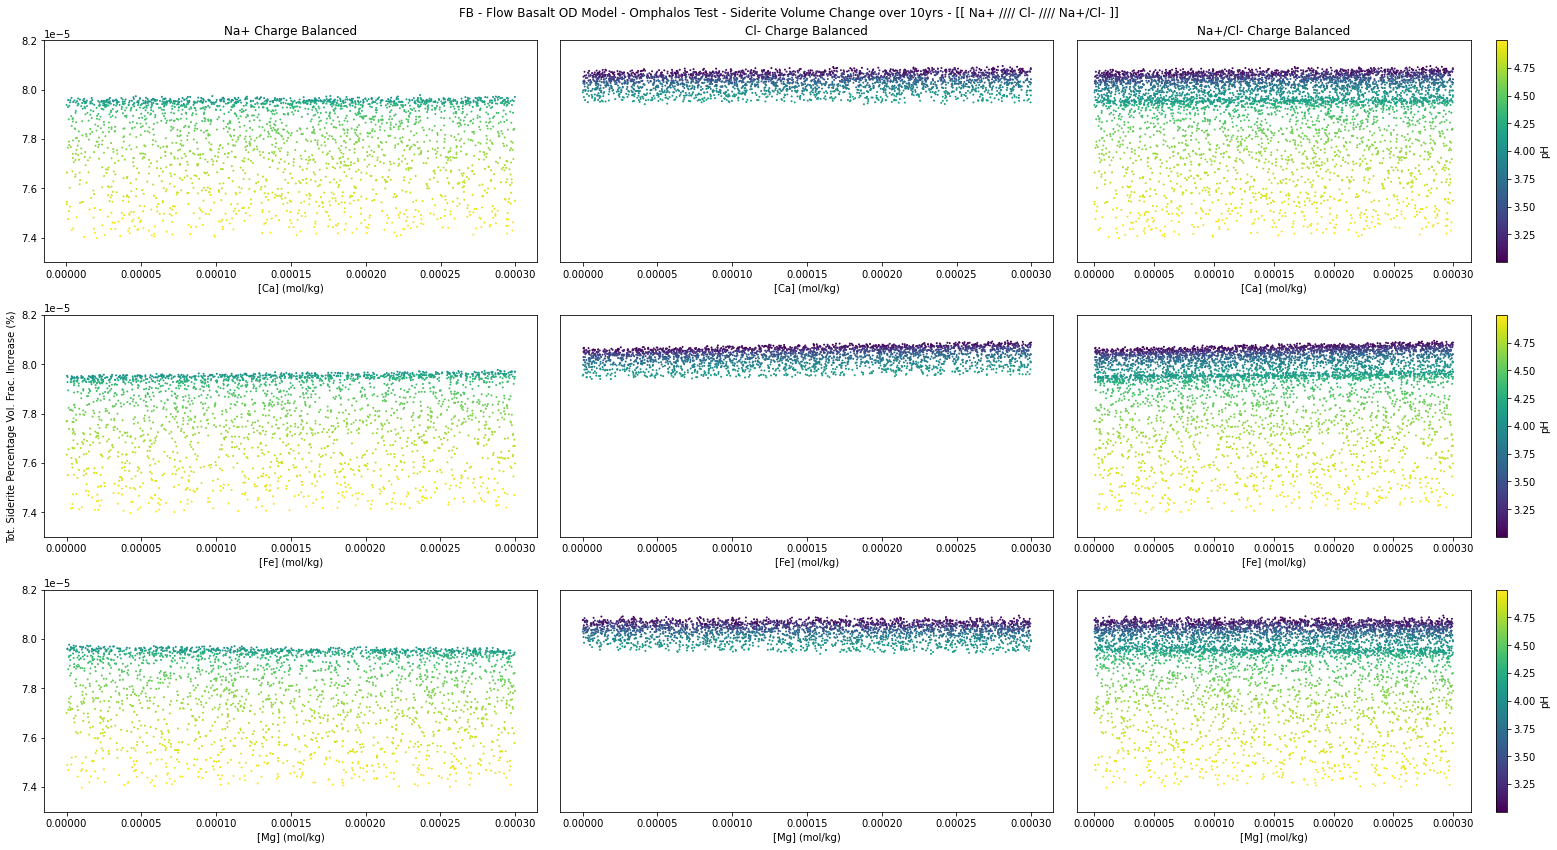

In [12]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Siderite Volume Change over 10yrs - [[ Na+ //// Cl- //// Na+/Cl- ]]')

fig.set_figheight(12)
fig.set_figwidth(22)

ax1.set_title("Na+ Charge Balanced", loc='center')
ax2.set_title("Cl- Charge Balanced", loc='center')
ax3.set_title("Na+/Cl- Charge Balanced", loc='center')

ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax7.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax3.set_xlabel('[Ca++] (mol/kg)')
ax6.set_xlabel('[Fe++] (mol/kg)')
ax9.set_xlabel('[Mg++] (mol/kg)')

ax1.yaxis.label.set_visible(False)
ax7.yaxis.label.set_visible(False)

ax1.xaxis.set_label_text('[Ca] (mol/kg)')
ax2.xaxis.set_label_text('[Ca] (mol/kg)')
ax3.xaxis.set_label_text('[Ca] (mol/kg)')
ax4.xaxis.set_label_text('[Fe] (mol/kg)')
ax5.xaxis.set_label_text('[Fe] (mol/kg)')
ax6.xaxis.set_label_text('[Fe] (mol/kg)')
ax7.xaxis.set_label_text('[Mg] (mol/kg)')
ax8.xaxis.set_label_text('[Mg] (mol/kg)')
ax9.xaxis.set_label_text('[Mg] (mol/kg)')

ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)
ax6.axes.yaxis.set_visible(False)
ax8.axes.yaxis.set_visible(False)
ax9.axes.yaxis.set_visible(False)

ax1.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax2.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax3.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax4.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax5.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax6.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax7.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax8.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax9.set_ylim(bottom=7.3e-5, top=8.2e-5)

_min, _max = np.amin(attributes_all_df['pH'].values.astype(float)), np.amax(attributes_all_df['pH'].values.astype(float))

ax1_x = attributes_all_df["Ca++"].values[0:len(dataset_na_dict)]
ax1_y = DeltVolFrac_TenYr_ds.Siderite.values[0:len(dataset_na_dict)]
ax1_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax2_x = attributes_all_df["Ca++"].values[len(dataset_na_dict):]
ax2_y = DeltVolFrac_TenYr_ds.Siderite.values[len(dataset_na_dict):]
ax2_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax3_x = attributes_all_df["Ca++"].values
ax3_y = DeltVolFrac_TenYr_ds.Siderite.values
ax3_c = attributes_all_df['pH'].values.astype(float)

ax4_x = attributes_all_df["Fe++"].values[0:len(dataset_na_dict)]
ax4_y = DeltVolFrac_TenYr_ds.Siderite.values[0:len(dataset_na_dict)]
ax4_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax5_x = attributes_all_df["Fe++"].values[len(dataset_na_dict):]
ax5_y = DeltVolFrac_TenYr_ds.Siderite.values[len(dataset_na_dict):]
ax5_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax6_x = attributes_all_df["Fe++"].values
ax6_y = DeltVolFrac_TenYr_ds.Siderite.values
ax6_c = attributes_all_df['pH'].values.astype(float)

ax7_x = attributes_all_df["Mg++"].values[0:len(dataset_na_dict)]
ax7_y = DeltVolFrac_TenYr_ds.Siderite.values[0:len(dataset_na_dict)]
ax7_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax8_x = attributes_all_df["Mg++"].values[len(dataset_na_dict):]
ax8_y = DeltVolFrac_TenYr_ds.Siderite.values[len(dataset_na_dict):]
ax8_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax9_x = attributes_all_df["Mg++"].values
ax9_y = DeltVolFrac_TenYr_ds.Siderite.values
ax9_c = attributes_all_df['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, c=ax1_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im2 = ax2.scatter(x=ax2_x, y=ax2_y, c=ax2_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im3 = ax3.scatter(x=ax3_x, y=ax3_y, c=ax3_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im4 = ax4.scatter(x=ax4_x, y=ax4_y, c=ax4_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im5 = ax5.scatter(x=ax5_x, y=ax5_y, c=ax5_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im6 = ax6.scatter(x=ax6_x, y=ax6_y, c=ax6_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im7 = ax7.scatter(x=ax7_x, y=ax7_y, c=ax7_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im8 = ax8.scatter(x=ax8_x, y=ax8_y, c=ax8_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im9 = ax9.scatter(x=ax9_x, y=ax9_y, c=ax9_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)

fig.colorbar(im1, ax=ax3, label='pH')
fig.colorbar(im4, ax=ax6, label='pH')
fig.colorbar(im7, ax=ax9, label='pH')

fig.tight_layout()

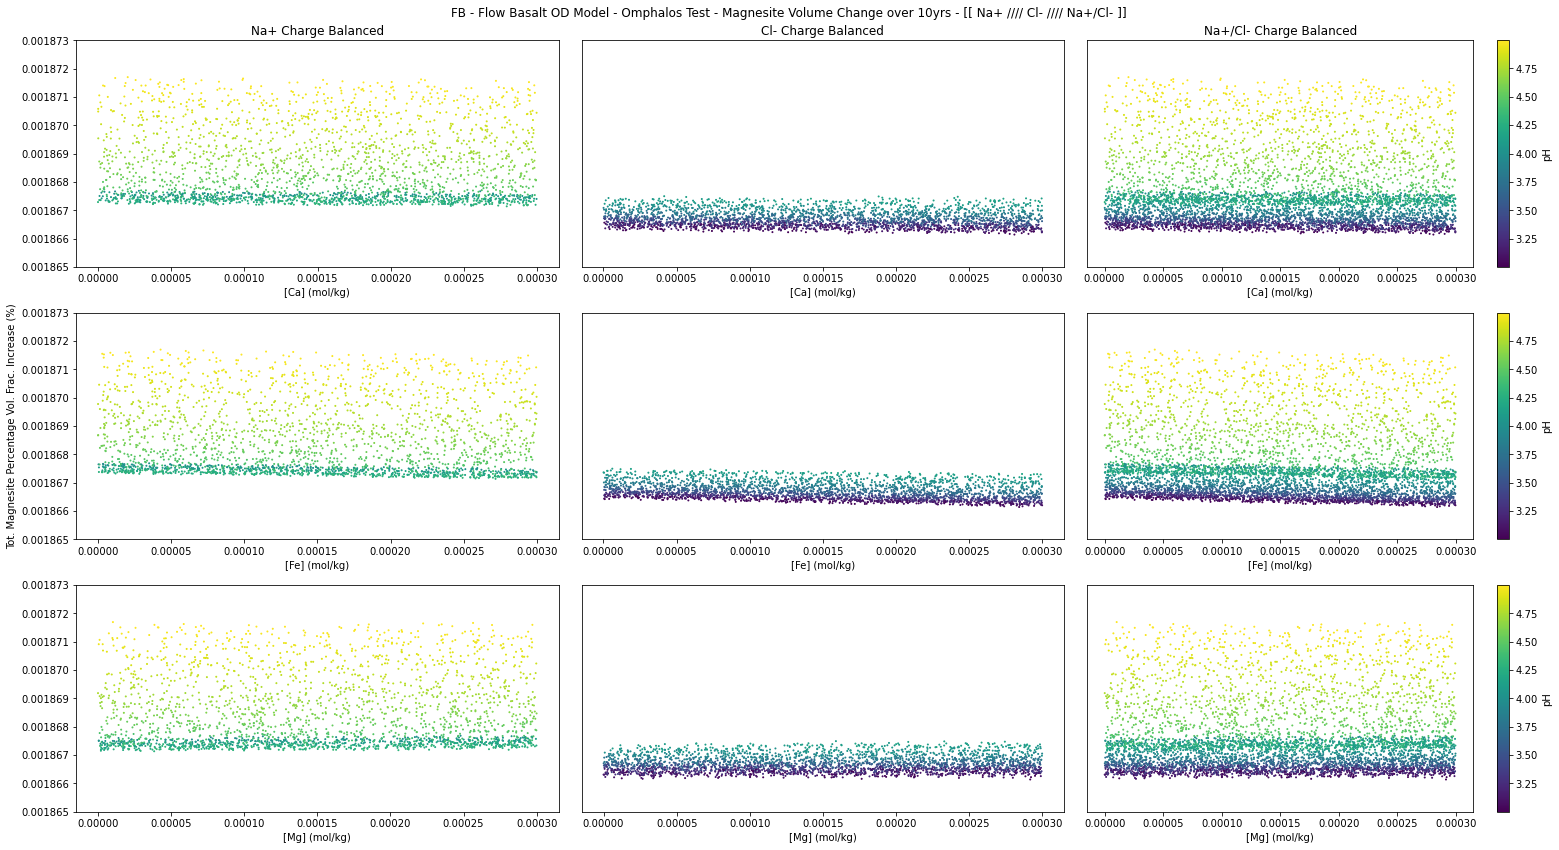

In [13]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - [[ Na+ //// Cl- //// Na+/Cl- ]]')

fig.set_figheight(12)
fig.set_figwidth(22)

ax1.set_title("Na+ Charge Balanced", loc='center')
ax2.set_title("Cl- Charge Balanced", loc='center')
ax3.set_title("Na+/Cl- Charge Balanced", loc='center')

ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax7.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_xlabel('[Ca++] (mol/kg)')
ax6.set_xlabel('[Fe++] (mol/kg)')
ax9.set_xlabel('[Mg++] (mol/kg)')

ax1.yaxis.label.set_visible(False)
ax7.yaxis.label.set_visible(False)

ax1.xaxis.set_label_text('[Ca] (mol/kg)')
ax2.xaxis.set_label_text('[Ca] (mol/kg)')
ax3.xaxis.set_label_text('[Ca] (mol/kg)')
ax4.xaxis.set_label_text('[Fe] (mol/kg)')
ax5.xaxis.set_label_text('[Fe] (mol/kg)')
ax6.xaxis.set_label_text('[Fe] (mol/kg)')
ax7.xaxis.set_label_text('[Mg] (mol/kg)')
ax8.xaxis.set_label_text('[Mg] (mol/kg)')
ax9.xaxis.set_label_text('[Mg] (mol/kg)')

ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)
ax6.axes.yaxis.set_visible(False)
ax8.axes.yaxis.set_visible(False)
ax9.axes.yaxis.set_visible(False)

ax1.set_ylim(bottom=0.001865, top=0.001873)
ax2.set_ylim(bottom=0.001865, top=0.001873)
ax3.set_ylim(bottom=0.001865, top=0.001873)
ax4.set_ylim(bottom=0.001865, top=0.001873)
ax5.set_ylim(bottom=0.001865, top=0.001873)
ax6.set_ylim(bottom=0.001865, top=0.001873)
ax7.set_ylim(bottom=0.001865, top=0.001873)
ax8.set_ylim(bottom=0.001865, top=0.001873)
ax9.set_ylim(bottom=0.001865, top=0.001873)

_min, _max = np.amin(attributes_all_df['pH'].values.astype(float)), np.amax(attributes_all_df['pH'].values.astype(float))

ax1_x = attributes_all_df["Ca++"].values[0:len(dataset_na_dict)]
ax1_y = DeltVolFrac_TenYr_ds.Magnesite.values[0:len(dataset_na_dict)]
ax1_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax2_x = attributes_all_df["Ca++"].values[len(dataset_na_dict):]
ax2_y = DeltVolFrac_TenYr_ds.Magnesite.values[len(dataset_na_dict):]
ax2_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax3_x = attributes_all_df["Ca++"].values
ax3_y = DeltVolFrac_TenYr_ds.Magnesite.values
ax3_c = attributes_all_df['pH'].values.astype(float)

ax4_x = attributes_all_df["Fe++"].values[0:len(dataset_na_dict)]
ax4_y = DeltVolFrac_TenYr_ds.Magnesite.values[0:len(dataset_na_dict)]
ax4_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax5_x = attributes_all_df["Fe++"].values[len(dataset_na_dict):]
ax5_y = DeltVolFrac_TenYr_ds.Magnesite.values[len(dataset_na_dict):]
ax5_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax6_x = attributes_all_df["Fe++"].values
ax6_y = DeltVolFrac_TenYr_ds.Magnesite.values
ax6_c = attributes_all_df['pH'].values.astype(float)

ax7_x = attributes_all_df["Mg++"].values[0:len(dataset_na_dict)]
ax7_y = DeltVolFrac_TenYr_ds.Magnesite.values[0:len(dataset_na_dict)]
ax7_c = attributes_all_df['pH'].values.astype(float)[0:len(dataset_na_dict)]

ax8_x = attributes_all_df["Mg++"].values[len(dataset_na_dict):]
ax8_y = DeltVolFrac_TenYr_ds.Magnesite.values[len(dataset_na_dict):]
ax8_c = attributes_all_df['pH'].values.astype(float)[len(dataset_na_dict):]

ax9_x = attributes_all_df["Mg++"].values
ax9_y = DeltVolFrac_TenYr_ds.Magnesite.values
ax9_c = attributes_all_df['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, c=ax1_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im2 = ax2.scatter(x=ax2_x, y=ax2_y, c=ax2_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im3 = ax3.scatter(x=ax3_x, y=ax3_y, c=ax3_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im4 = ax4.scatter(x=ax4_x, y=ax4_y, c=ax4_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im5 = ax5.scatter(x=ax5_x, y=ax5_y, c=ax5_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im6 = ax6.scatter(x=ax6_x, y=ax6_y, c=ax6_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im7 = ax7.scatter(x=ax7_x, y=ax7_y, c=ax7_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im8 = ax8.scatter(x=ax8_x, y=ax8_y, c=ax8_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)
im9 = ax9.scatter(x=ax9_x, y=ax9_y, c=ax9_c, s=1, cmap="viridis", vmin = _min, vmax = _max, alpha=1)

fig.colorbar(im1, ax=ax3, label='pH')
fig.colorbar(im4, ax=ax6, label='pH')
fig.colorbar(im7, ax=ax9, label='pH')

fig.tight_layout()